##### Title: Monitoring how RTT varies based on the geolocation of the target
##### Author: Lotito Davide Pio
##### Date: 22/04/2022
<img src="./images/logoUnipvST.jpg" width="75" height="75">

## Some useful imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
from glob import glob
import getCoordinate
import haversine as hs
import math

## Read all files and create a unique dataframe 

In [2]:
dirPath = '../results/'
allFiles = glob(os.path.join(dirPath, "*.txt"))
indDf = (pd.read_json(f) for f in allFiles)
df = pd.concat(indDf, ignore_index=True)
df.drop('time', axis=1, inplace=True)
df

,destination,date,packetLost,excutionTime,minRTT,avgRTT,maxRTT,devRTT
0,34.71.44.40,2022-04-18,0%,9013ms,129.369,132.916,144.675,4.565
1,35.236.81.238,2022-04-18,0%,9011ms,170.274,172.740,178.484,2.788
2,34.74.209.9,2022-04-18,0%,9010ms,116.419,120.695,140.447,6.895
3,34.151.215.105,2022-04-18,0%,9011ms,218.832,222.232,239.276,5.926
4,34.129.235.109,2022-04-18,0%,9010ms,291.306,292.996,298.187,1.961
...,...,...,...,...,...,...,...,...
295,34.85.87.24,2022-04-18,0%,9011ms,247.994,262.270,335.731,25.178
296,34.131.76.108,2022-04-18,0%,9010ms,274.681,286.609,358.669,24.408
297,34.101.215.255,2022-04-18,0%,9010ms,266.289,280.166,350.840,23.988
298,34.88.168.220,2022-04-18,0%,9012ms,54.037,60.711,76.667,7.981


## Coordinates of the IPs

In [3]:
IP_list = df['destination'].tolist()
IP_list = list(dict.fromkeys(IP_list)) #remove duplicated elements

## Draw location of the IPs on the global map

My IP is: 34.71.44.40 and my coordinates are POINT (-97 37)
My IP is: 35.236.81.238 and my coordinates are POINT (-118 34)
My IP is: 34.74.209.9 and my coordinates are POINT (-79 32)
My IP is: 34.151.215.105 and my coordinates are POINT (-46 -23)
My IP is: 34.129.235.109 and my coordinates are POINT (144 -37)
My IP is: 34.85.87.24 and my coordinates are POINT (139 35)
My IP is: 34.131.76.108 and my coordinates are POINT (77 28)
My IP is: 34.101.215.255 and my coordinates are POINT (106 -6)
My IP is: 34.88.168.220 and my coordinates are POINT (28 61)
My IP is: 34.65.88.164 and my coordinates are POINT (8 47)


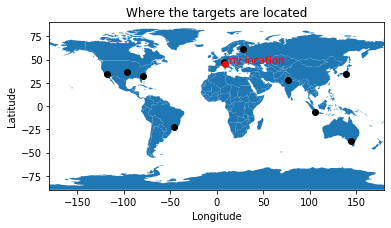

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

points = gpd.GeoDataFrame() # Point(longitudine, latitudine)

my_points = {}
for ip in IP_list:
    point = Point(getCoordinate.coordinates(ip))
    os.system("sleep 1")# wait for free API 
    my_points[ip] = point

# API wrong IPs 
my_points["34.151.215.105"] = (Point(-46,-23))
my_points["34.129.235.109"] = (Point(144,-37))
my_points["34.131.76.108"] = (Point(77,28))

for ip, loc in my_points.items():
    print(f"My IP is: {ip} and my coordinates are {loc}")

points["geometry"] = gpd.GeoSeries(my_points)
ax = world.plot()
points.plot(color="k", ax=ax)

my_point = Point(9, 45)
my_location = gpd.GeoSeries(my_point)
my_location.plot(color="r", ax=ax)

plt.text(my_point.x+1,my_point.y+1,"my location", color='red')
plt.rcParams["figure.figsize"] = (25, 10)
plt.title("Where the targets are located")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Calculate distance between my location and target IP

Add the coordinates to each IP

In [5]:
for ip, loc in my_points.items():
    lines = (df[df["destination"] == ip])
    for ind in lines.index:
        df.at[ind, 'Longitude'] = loc.x
        df.at[ind, 'Latitude'] = loc.y

Calculate the distance and add the value to each row

In [6]:
for ind in df.index:
    d = hs.haversine((my_point.y, my_point.x),(df.at[ind, 'Latitude'], df.at[ind, 'Longitude'])) #lat, long
    df.at[ind, 'distance'] = d

## Sort by shortest distance

In [7]:
df = df.sort_values(['distance']).reset_index(drop=True)
df

,destination,date,packetLost,excutionTime,minRTT,avgRTT,maxRTT,devRTT,Longitude,Latitude,distance
0,34.65.88.164,2022-04-18,0%,9012ms,17.901,19.987,24.809,1.946,8.0,47.0,235.417010
1,34.65.88.164,2022-04-18,0%,9013ms,17.597,25.050,81.361,18.819,8.0,47.0,235.417010
2,34.65.88.164,2022-04-18,0%,9013ms,17.703,23.751,52.961,9.885,8.0,47.0,235.417010
3,34.65.88.164,2022-04-18,0%,9013ms,17.394,20.778,30.402,4.866,8.0,47.0,235.417010
4,34.65.88.164,2022-04-18,0%,9011ms,18.289,20.488,25.647,2.526,8.0,47.0,235.417010
...,...,...,...,...,...,...,...,...,...,...,...
295,34.129.235.109,2022-04-18,0%,9009ms,290.789,294.421,304.632,4.231,144.0,-37.0,16187.205013
296,34.129.235.109,2022-04-18,0%,9009ms,291.041,302.057,368.995,22.396,144.0,-37.0,16187.205013
297,34.129.235.109,2022-04-18,0%,9011ms,290.869,305.149,406.196,33.916,144.0,-37.0,16187.205013
298,34.129.235.109,2022-04-18,0%,9012ms,294.166,295.968,300.704,1.905,144.0,-37.0,16187.205013


In [8]:
IP_list = list(dict.fromkeys(df['destination'].tolist()))

In [9]:
targets = { "davide-iowa" : "34.71.44.40",
            "davide-cali" : "35.236.81.238",
            "davide-carol" : "34.74.209.9",
            "davide-brazil" : "34.151.215.105",
            "davide-australia" : "34.129.235.109",
            "davide-asia" : "34.85.87.24",
            "davide-asia2" : "34.131.76.108",
            "davide-asia3" : "34.101.215.255",
            "davide-eu" : "34.88.168.220",
            "davide-eu2" : "34.65.88.164"}
key_list = list(targets.keys())
val_list = list(targets.values())

## Graphs

Values of the avgRTT for each target

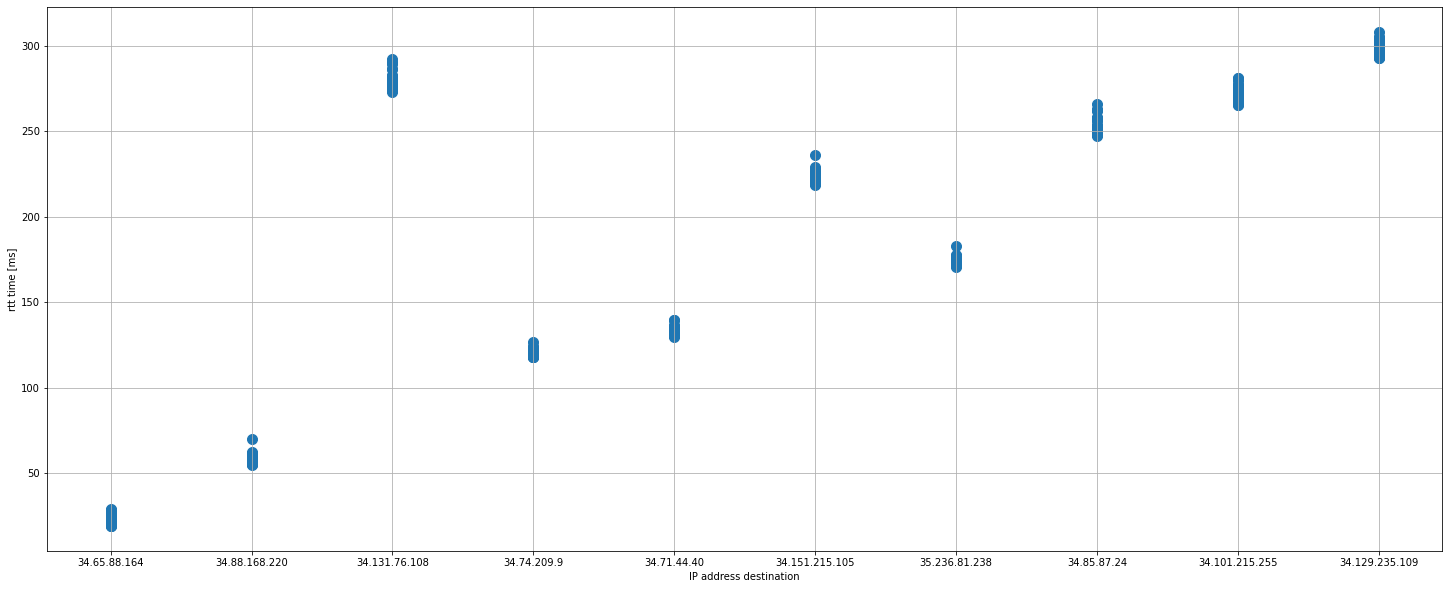

In [10]:
df.plot.scatter(x = 'destination', y = 'avgRTT', s = 100)
plt.grid()
plt.xlabel("IP address destination")
plt.ylabel("rtt time [ms]")
plt.rcParams["figure.figsize"] = (20, 7)

The trend of the 'avgRTT' with respect to the position is shown

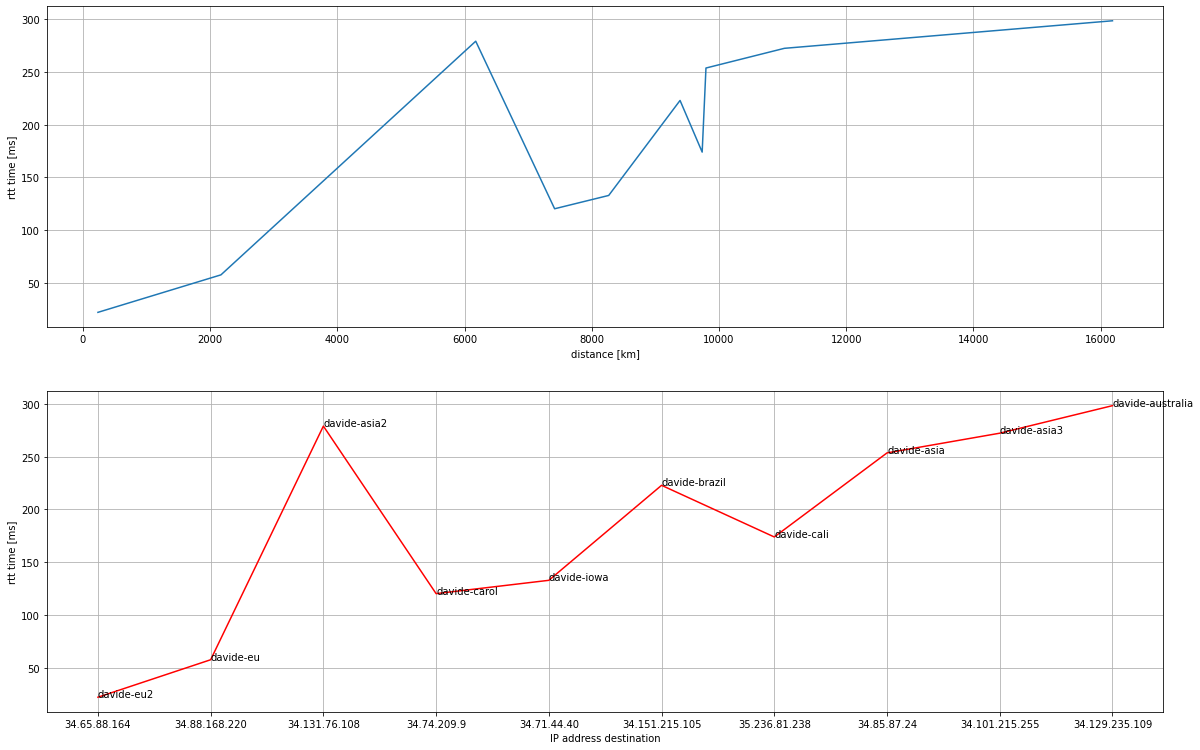

In [11]:
plt.subplot(2,1,1)
df.groupby("distance").avgRTT.mean().plot()
plt.xlabel("distance [km]")
plt.ylabel("rtt time [ms]")
plt.grid()

plt.subplot(2,1,2)
y = df.groupby("distance").avgRTT.mean()
plt.plot(IP_list,y, 'r')
for xy in zip(IP_list, y):
    s = key_list[val_list.index(xy[0])]
    plt.annotate(s, xy=xy, textcoords='data')
plt.xlabel("IP address destination")
plt.ylabel("rtt time [ms]")
plt.grid()

plt.subplots_adjust(bottom=0.1,top=1.5)
plt.rcParams["figure.figsize"] = (14, 7)

The graph of the 'devRTT' or the standard deviation for each IP is shown

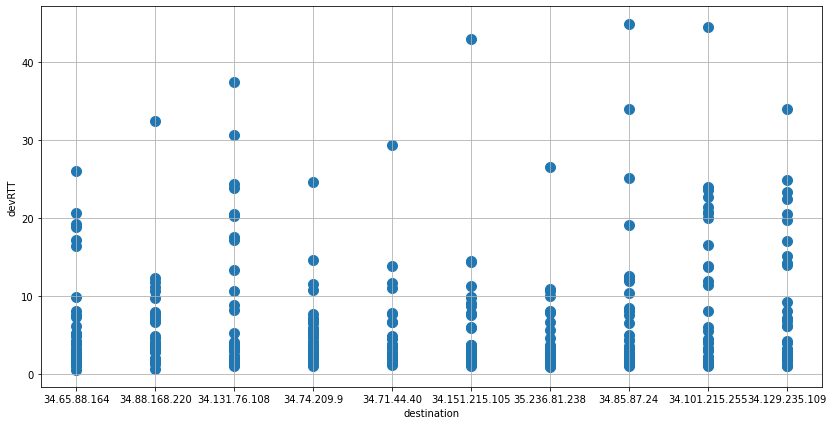

In [12]:
df.plot.scatter(x = 'destination', y = 'devRTT', s = 100)
plt.grid()